In [300]:
import os
import math

import gzip
import pickle
import itertools
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from keras.utils import np_utils
from keras.models import Sequential

from sklearn import cross_validation
from keras.optimizers import RMSprop, SGD
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Activation, Dropout
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping, TensorBoard
%matplotlib inline

# MNIST DataSet Preparation

In [301]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

# USPS DataSet Preparation

In [302]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)
usps_test_data = np.asarray(USPSMat)
usps_test_label = np.asarray(USPSTar)

# Generate Confusion Matrix

In [303]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [304]:
def generate_confusion_matrix(test_label_act, 
                              test_label_pred, 
                              data_type):
    
    plt.figure(figsize=(9,6))
    usps_conf_matrix = metrics.confusion_matrix(test_label_act, test_label_pred)
    
    plot_confusion_matrix(usps_conf_matrix, classes=np.arange(0,10),
                        title='Confusion matrix, '+data_type)

# Logistic Regression

In [305]:
def softmax_func(z):
    numerator = np.exp (z)
    demominator =  np.exp(z).sum(axis=1)
    demominator = demominator.reshape(z.shape[0],1)
    return numerator/demominator

In [306]:
def train_model_logistic():
    
    learningRate = 0.05
    batchsize = 55
    
    lowerbound = training_data[0].shape[0]
    bias = np.ones([training_data[0].shape[0],1])
    training_input = np.concatenate((training_data[0], bias), axis=1)
    training_label = training_data[1]
    W_Now = np.ones((training_input.shape[1], 10))
    
    for i in range(0, lowerbound, batchsize):
        
        training_data_mini = training_input[i:i+batchsize]
        training_target_mini = training_label[i:i+batchsize]
        training_target_mini_v =  (np.arange(10) == training_target_mini[:, None]).astype(float)

        step1 = softmax_func(np.dot(training_data_mini, W_Now))
        step2 = np.subtract(np.transpose(step1), training_target_mini_v.T)
        
        Delta_E_D =  np.dot(np.transpose(training_data_mini), step2.T)
        Delta_W       = -(learningRate * Delta_E_D)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next
    
    return W_T_Next

In [307]:
def predict_logistic(predict_data, W_T_Next):
    
    bias = np.ones([predict_data.shape[0], 1])
    predict_input = np.concatenate((predict_data, bias), axis=1)
    predict_output   = np.argmax(softmax_func(np.dot(predict_input, W_T_Next)), axis = 1)
    
    return predict_output

In [308]:
def get_accuracy_logistic(VAL_TEST_OUT,ValDataAct):
    
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    
    for i in range (0,len(VAL_TEST_OUT)):
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    
    accuracy_TR = (float((counter*100))/float(len(VAL_TEST_OUT)))
    
    return accuracy_TR


*****************************************************
*                      MNIST                        *
*****************************************************

Accuracy Training MNIST = 89.406
Accuracy Validation MNIST = 90.26
Accuracy Testing MNIST = 89.93


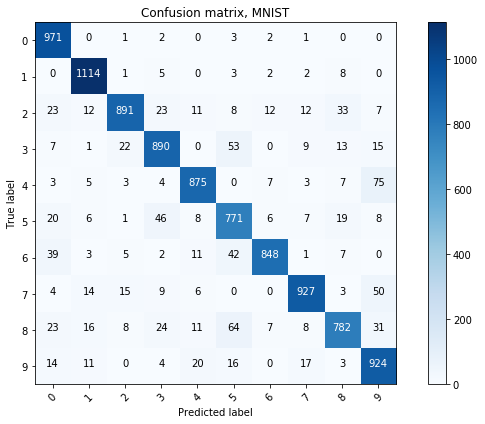

In [309]:
W_T_Next = train_model_logistic()

print("\n*****************************************************")
print("*                      MNIST                        *")
print("*****************************************************\n")

predicted_label = predict_logistic(training_data[0], W_T_Next)
accuracy = get_accuracy_logistic(predicted_label, training_data[1])
print ("Accuracy Training MNIST = " + str(np.around(accuracy,5)))

predicted_label = predict_logistic(validation_data[0], W_T_Next)
accuracy = get_accuracy_logistic(predicted_label, validation_data[1])
print ("Accuracy Validation MNIST = " + str(np.around(accuracy,5)))

mnist_pred_label_logistic = predict_logistic(test_data[0], W_T_Next)
accuracy = get_accuracy_logistic(mnist_pred_label_logistic, test_data[1])
print ("Accuracy Testing MNIST = " + str(np.around(accuracy,5)))

generate_confusion_matrix(test_data[1], mnist_pred_label_logistic, 'MNIST')


*****************************************************
*                      USPS                         *
*****************************************************

Accuracy Testing USPS = 32.97165


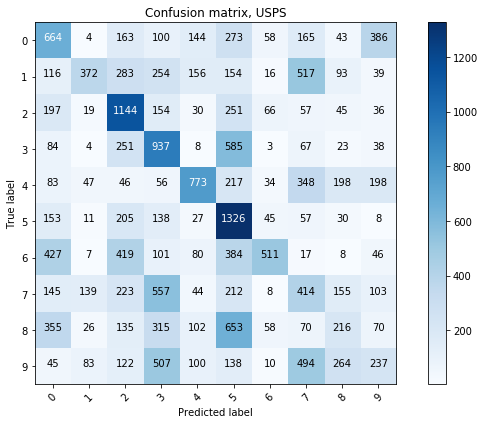

In [310]:
print("\n*****************************************************")
print("*                      USPS                         *")
print("*****************************************************\n")

usps_predicted_label_logistic = predict_logistic(usps_test_data, W_T_Next)
accuracy = get_accuracy_logistic(usps_predicted_label_logistic, usps_test_label)
print ("Accuracy Testing USPS = " + str(np.around(accuracy,5)))

generate_confusion_matrix(usps_test_label, usps_predicted_label_logistic, 'USPS')

# Neural Network

In [311]:
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer_nodes = 256
final_layer_nodes = 10

# We define a model 
def get_model(input_size):
    
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(final_layer_nodes))
    model.add(Activation('softmax'))
    
    model.summary()
    
    model.compile(optimizer='RMSprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [312]:
def train_model_nn():
    validation_data_split = 0.2
    num_epochs = 10000  
    model_batch_size = 100
    tb_batch_size = 32
    early_patience = 20
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
    processedLabel_training = np_utils.to_categorical(training_data[1],10)
    model = get_model(training_data[0].shape[1])
    history = model.fit(training_data[0]
                    , np_utils.to_categorical(training_data[1],10)
                    , validation_data=(validation_data[0], np_utils.to_categorical(validation_data[1],10))
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))
    return model

In [313]:
def predict_target_nn(model, 
                      testing_data, 
                      testing_label):
    
    pred_label = model.predict(testing_data).argmax(axis=-1)
    testing_accuracy = accuracy_score(testing_label, pred_label)
    return pred_label, testing_accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_40 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_41 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                2570      
__________

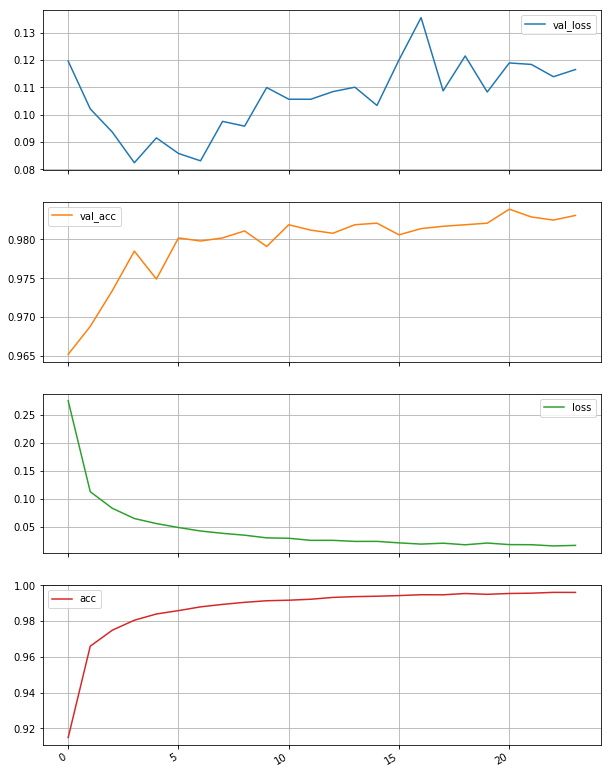

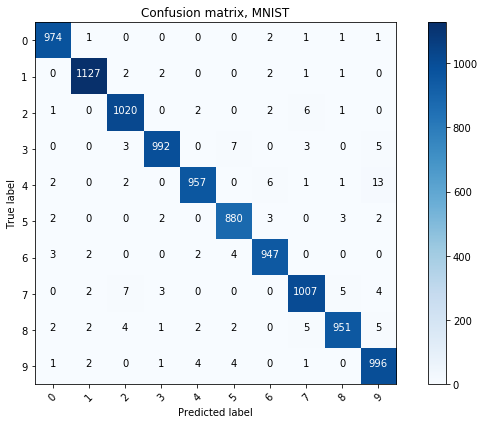

In [314]:
model = train_model_nn()

print("\n*****************************************************")
print("*                      MNIST                        *")
print("*****************************************************\n")


mnist_pred_label_nn , accuracy = predict_target_nn(model, test_data[0], test_data[1])
print("Testing Accuracy MNIST: " + str(accuracy*100))

generate_confusion_matrix(test_data[1], mnist_pred_label_nn, 'MNIST')


*****************************************************
*                      USPS                         *
*****************************************************

Testing Accuracy USPS: 44.96724836241812


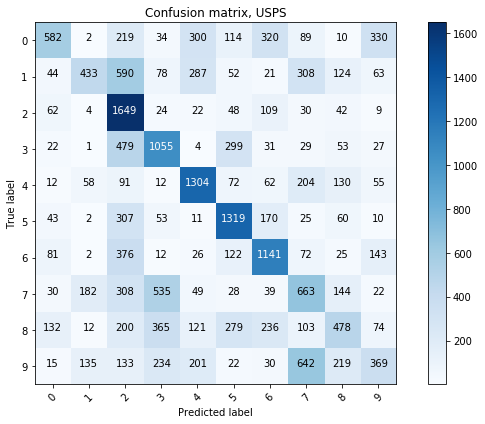

In [315]:
print("\n*****************************************************")
print("*                      USPS                         *")
print("*****************************************************\n")

usps_pred_label_nn , accuracy = predict_target_nn(model, usps_test_data, usps_test_label)
print("Testing Accuracy USPS: " + str(accuracy*100))

generate_confusion_matrix(usps_test_label, usps_pred_label_nn, 'USPS')

# Support Vector Machine

In [316]:
def train_model_svm():
    
    classifier = svm.SVC(C=2.0, kernel='rbf', gamma=0.005)
    classifier.fit(training_data[0], training_data[1])
    return classifier

In [317]:
def predict_target_svm(classifier, 
                       testing_data, 
                       testing_label):
    
    pred_label = classifier.predict(testing_data)
    accuracy = accuracy_score(testing_label, pred_label)
    return pred_label, accuracy


*****************************************************
*                      MNIST                        *
*****************************************************

SVM Accuracy MNIST: 97.11


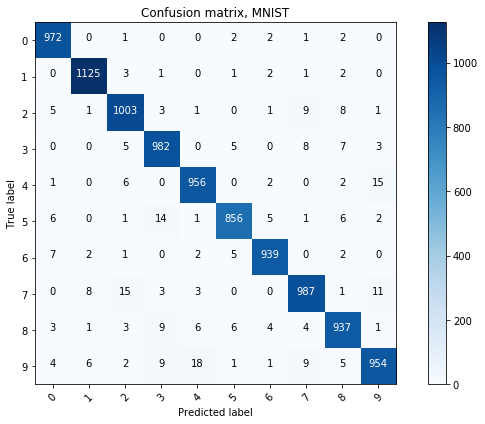

In [318]:
classifier = train_model_svm()

print("\n*****************************************************")
print("*                      MNIST                        *")
print("*****************************************************\n")

mnist_pred_label_svm, accuracy = predict_target_svm(classifier, test_data[0], test_data[1])
print("SVM Accuracy MNIST: " + str(accuracy*100))

generate_confusion_matrix(test_data[1], mnist_pred_label_svm, 'MNIST')


*****************************************************
*                      USPS                         *
*****************************************************

SVM Accuracy MNIST: 39.966998349917496


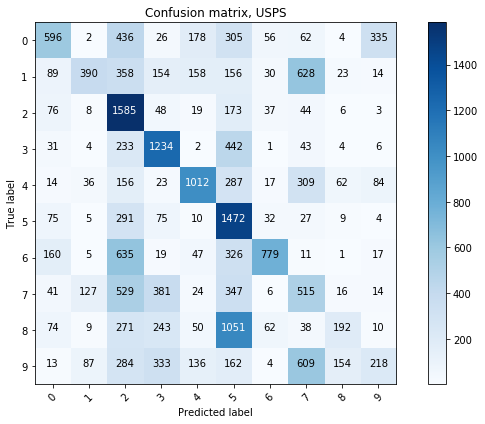

In [319]:
print("\n*****************************************************")
print("*                      USPS                         *")
print("*****************************************************\n")

usps_pred_label_svm, accuracy = predict_target_svm(classifier, usps_test_data, usps_test_label)
print("SVM Accuracy MNIST: " + str(accuracy*100))

generate_confusion_matrix(usps_test_label, usps_pred_label_svm, 'USPS')

# Random Forest Classification

In [320]:
def train_model_rfc():
    
    classifier = RandomForestClassifier(n_estimators=500)
    classifier.fit(training_data[0], training_data[1])
    return classifier

In [321]:
def predict_target_rfc(classifier, 
                       testing_data, 
                       testing_label):
    
    pred_label = classifier.predict(testing_data)
    accuracy = accuracy_score(testing_label, pred_label)
    return pred_label, accuracy


*****************************************************
*                      MNIST                        *
*****************************************************

RFC Accuracy MNIST: 96.95


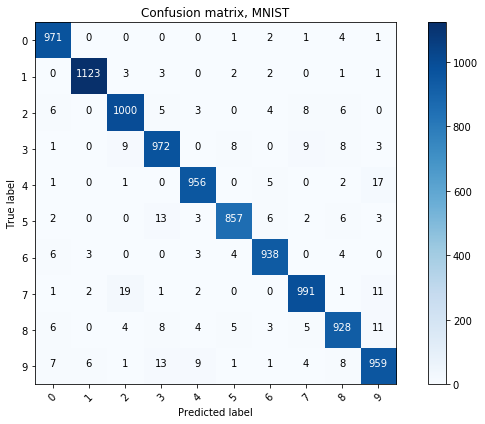

In [322]:
classifier = train_model_rfc()

print("\n*****************************************************")
print("*                      MNIST                        *")
print("*****************************************************\n")

mnist_pred_label_rfc, accuracy = predict_target_rfc(classifier, test_data[0], test_data[1])
print("RFC Accuracy MNIST: " + str(accuracy*100))

generate_confusion_matrix(test_data[1], mnist_pred_label_rfc, 'MNIST')


*****************************************************
*                      USPS                         *
*****************************************************

RFC Accuracy MNIST: 40.65703285164258


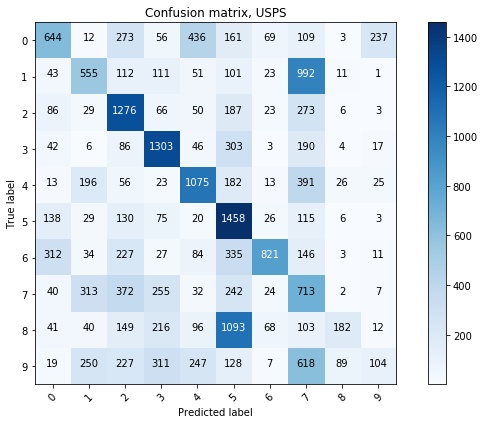

In [323]:
print("\n*****************************************************")
print("*                      USPS                         *")
print("*****************************************************\n")

usps_pred_label_rfc, accuracy = predict_target_rfc(classifier, usps_test_data, usps_test_label)
print("RFC Accuracy MNIST: " + str(accuracy*100))

generate_confusion_matrix(usps_test_label, usps_pred_label_rfc, 'USPS')

# Ensemble Models : Hard Voting

In [324]:
def ensemble_model(pred_label_logistic, 
                   pred_label_nn, 
                   pred_label_svm, 
                   pred_label_rfc):
    
    pred_label_comb = []
    for i in range (pred_label_logistic.shape[0]):
        count_matrix = np.zeros(10)
        count_matrix[pred_label_logistic[i]] += 1
        count_matrix[pred_label_nn[i]] += 1
        count_matrix[pred_label_svm[i]] += 1
        count_matrix[pred_label_rfc[i]] += 1
        pred_label_comb.append(np.argmax(count_matrix, axis=0))
    return pred_label_comb


*****************************************************
*                      MNIST                        *
*****************************************************

Testing Accuracy MNIST: 97.25


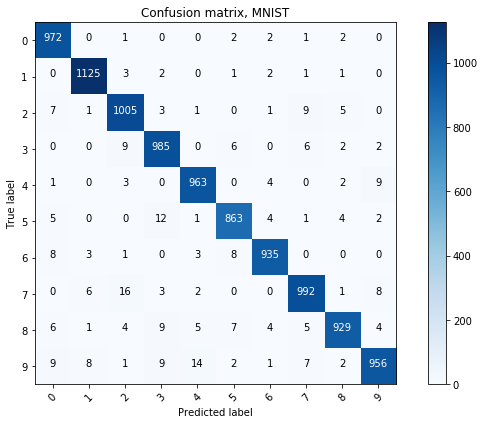

In [325]:
print("\n*****************************************************")
print("*                      MNIST                        *")
print("*****************************************************\n")

mnist_pred_label_comb = ensemble_model(mnist_pred_label_logistic, mnist_pred_label_nn, mnist_pred_label_svm, mnist_pred_label_rfc)
mnist_testing_accuracy_comb = accuracy_score(test_data[1], mnist_pred_label_comb)
print("Testing Accuracy MNIST: " + str(mnist_testing_accuracy_comb*100))

generate_confusion_matrix(test_data[1], mnist_pred_label_comb, 'MNIST')


*****************************************************
*                      USPS                         *
*****************************************************

Testing Accuracy USPS: 41.35206760338017


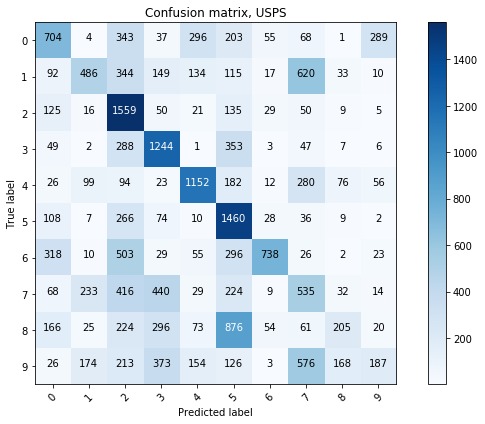

In [326]:
print("\n*****************************************************")
print("*                      USPS                         *")
print("*****************************************************\n")

usps_pred_label_comb = ensemble_model(usps_predicted_label_logistic, usps_pred_label_nn, usps_pred_label_svm, usps_pred_label_rfc)
usps_test_accuracy_comb = accuracy_score(usps_test_label, usps_pred_label_comb)
print("Testing Accuracy USPS: " + str(usps_test_accuracy_comb*100))

generate_confusion_matrix(usps_test_label, usps_pred_label_comb, 'USPS')